<a href="https://colab.research.google.com/github/cfoli/EMG-based-Gesture-Recognition/blob/main/EMG_based_Gesture_Prediction_Workspace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exploring different classical ML vs deep learning model architectures for optimal EMG-based gesture prediction

# Load EMG Data

In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow

emg_df = pd.read_csv('//content/drive/MyDrive/ML Projects/EMG Gesture Prediction/Datasets/EMG-data.csv')
print(emg_df.head())
print(emg_df.shape)


   time  channel1  channel2  channel3  channel4  channel5  channel6  channel7  \
0     1   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
1     5   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
2     6  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
3     7  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
4     8  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   

   channel8  class  label  
0  -0.00001      0      1  
1  -0.00001      0      1  
2   0.00001      0      1  
3   0.00001      0      1  
4   0.00001      0      1  
(4237907, 11)


# Explore Data

---



In [3]:
print("class :", emg_df["class"].unique())
print()
# print("Num. samples per class/gesture (all subjects) :\n",emg_df["class"].value_counts())

import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,2,figsize=(10, 4),dpi=350)
axes = axes.flatten()

emg_df["class"].value_counts(ascending=True).sort_index().plot(kind="pie", title="Num. Samples per Class",ax=axes[0])

# Set axis labels
plt.xlabel("Class")
plt.ylabel("Sample Count")

# Sort by label in ascending order before plotting
emg_df["label"].value_counts(ascending=True).sort_index().plot(kind="bar", title="Num. Samples per Subject",ax=axes[1])

# Set axis labels
plt.xlabel("Subject Id")
plt.xticks(rotation=45, fontsize=6)  # Rotate
plt.ylabel("Sample Count")

plt.suptitle("Sample Counts per Group")
plt.tight_layout()
plt.show()


class : [0 1 2 3 4 5 6 7]



# Extract Features and Labels from Data File

---



In [4]:
features = emg_df.drop(columns=["label","class","time"]).copy(deep=True)
display(features.head())
print('Feature shape: ',features.shape)

gesture = emg_df["class"]
print('Label count: ',gesture.shape)


channel1  channel2  channel3  channel4  channel5  channel6  channel7  \
0   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
1   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
2  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
3  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
4  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   

   channel8  
0  -0.00001  
1  -0.00001  
2   0.00001  
3   0.00001  
4   0.00001

Feature shape:  (4237907, 8)
Label count:  (4237907,)


# Plot time series features with task onset markers

---



In [24]:

def plot_multichannel_data(emg_df,channel_list,subject_id):
  import matplotlib.pyplot as plt
  import numpy as np
  matplotlib.use('inline')

  # supported backend values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template', 'inline']


  fig, ax = plt.subplots(figsize=(28,8),dpi=500)

  subject_df = emg_df[emg_df['label'] == subject_id].reset_index(drop=True)
  # plot class labels (gesture type) as a function of time
  ax.plot(subject_df.index,subject_df['class'],c='darkviolet',label='gesture')

  #----------------------------------------

  # Identify gesture onset times (where class changes)
  trial_onsets = np.where(subject_df['class'].diff() != 0)[0]
  gesture_idxs = subject_df['class'].iloc[trial_onsets]
  gesture_labels = ["unmarked","hand_rest","clenched_fist","wrist_flex","wrist_extend","radial_deviatxn","ulna_deviatxn","palm_extend"]

  # Assign a unique color per gesture type
  unique_gestures = gesture_idxs.unique()
  gc = plt.get_cmap('tab10', len(unique_gestures))  # Create colormap
  gesture_colors = {gesture: gc(idx) for idx, gesture in enumerate(unique_gestures)}
  onset_labels = {gesture: gesture_labels[idx] for idx, gesture in enumerate(unique_gestures)}

  # Plot vertical lines for each gesture onset
  for onset, gesture in zip(trial_onsets, gesture_idxs):
      ax.axvline(x=onset, color=gesture_colors[gesture], linestyle='-', alpha=1, linewidth=1.5)
      ax.text(onset, 6, onset_labels[gesture], color=gesture_colors[gesture], rotation=90, verticalalignment='top') # print out gesture label at trial onset

  #----------------------------------------

  sensor_colors = plt.get_cmap("tab20c") # tab20c,tab20b,Paired,tab20,
  for idx,chan in enumerate(channel_list):

    # plot time series EMG signals per sensor
    ax.plot(subject_df.index,subject_df[chan] * 1000 - 2.5*(idx+1), color=sensor_colors(idx), linewidth=0.5,alpha=1,label=chan)

  plt.title(f'EMG Data for Subject #{subject_id}',fontsize=30)
  plt.xlabel('Time (ms)',fontsize=24)
  # plt.ylabel('EMG (mV)',fontsize=14)
  plt.legend(fontsize=10)
  plt.tight_layout()
  plt.show()

channel_list = list(features.columns)
plot_multichannel_data(emg_df,channel_list = channel_list, subject_id=7)


# Stratified Train-test Split

---



In [65]:
# 75% training, 20% test. Train set will later be split into training and validation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, gesture, test_size=0.15, random_state=1, stratify=gesture)

print(f"train shape: {X_train.shape}")
print(f"test shape: {X_test.shape}")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Create a pipeline with StandardScaler followed by MinMaxScaler
scaler_pipeline = Pipeline([
    ('standardize', StandardScaler())  # Standardization: zero mean, unit variance
    # ('normalize', MinMaxScaler(feature_range=(0, 1)))  # Normalization: scale to [0,1]
])

# Apply the pipeline to training and test data
X_train = scaler_pipeline.fit_transform(X_train)  # Fit and transform training data
X_test = scaler_pipeline.transform(X_test)  # Transform test data

# one hot encode Labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test  = tf.keras.utils.to_categorical(y_test)


train shape: (3602220, 8)
test shape: (635687, 8)


# Lazy Classification

---



> Lazy Predict help build a lot of basic models without much code and helps understand which models works better without any parameter tuning



In [ ]:
# !pip install lazypredict
# !pip install dask[dataframe]

from lazypredict.Supervised import LazyRegressor, LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# Fit lazy classifier on a small subset of features
X_train_lc, X_test_lc, y_train_lc, y_test_lc = train_test_split(X_test, y_test, test_size=0.15, random_state=1, stratify=y_test)

import numpy as np

# Convert one-hot encoded labels back to integer labels
y_train_lc = np.argmax(y_train_lc, axis=1)
y_test_lc  = np.argmax(y_test_lc, axis=1)

lazy_classifier = LazyClassifier(verbose=0, random_state=12, classifiers=[
    # ('GaussianNB', GaussianNB),
    ('SVC', SVC),
    ('AdaBoostClassifier', AdaBoostClassifier)
],ignore_warnings=False)

lazy_models_summary , predictions = lazy_classifier.fit(X_train_lc, X_test_lc, y_train_lc, y_test_lc)
lazy_models_summary


# Classical ML Models

---



In [14]:

def fit_classical_ML_models(X, Y, model_type = "SVM", optimize_hyperparameters_TF = False):

    """
    Process neural data for tuning quality and yield across brain areas and tasks.

    Parameters:
        feature_maps (dict): Dictionary containing neural features and trial labels for different brain areas and tasks.
        model_type (str): Type of model to train ("SVM", "RandomForest",or "MLP").
        optimize_hyperparameters_TF (bool): Whether to optimize hyperparameters for the chosen model.
        use_best_features_only_TF (bool): Whether to use only the best features or all features for training.

    Returns:
        dict: Fitted models, training accuracies, and test accuracies for each brain area and task.

    Data: Feb 14.25.F [CxF]
    """

    from sklearn.model_selection import StratifiedKFold, GridSearchCV
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split
    import numpy as np
    from sklearn.metrics import classification_report, accuracy_score
    from keras import layers, Model  # Import Keras layers here

    # Encode class values as integers
    from sklearn import preprocessing
    encoder = preprocessing.LabelEncoder()
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y)

    num_classes = np.unique(Y).size
    input_shape = (X.shape[1],)

    # Perform training data augmentation if num. total trials is <=100
    augment_train_data_TF = True if encoded_Y.size<=100 else False

    # Initialize cross-validation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = None
    training_accuracies = []
    test_accuracies = []

    # Perform cross-validation manually
    for train_idx, test_idx in outer_cv.split(X, encoded_Y):
        print(f"K-Fold Validation ({model_type} model): test acc = ",end="")
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = encoded_Y[train_idx], encoded_Y[test_idx]

        # Create a pipeline with StandardScaler followed by MinMaxScaler
        scaler_pipeline = Pipeline([
            ('standardize', StandardScaler())  # Standardization: zero mean, unit variance
            # ('normalize', MinMaxScaler(feature_range=(0, 1)))  # Normalization: scale to [0,1]
        ])

        # Apply the pipeline to training and test data
        X_train = scaler_pipeline.fit_transform(X_train)  # Fit and transform training data
        X_test = scaler_pipeline.transform(X_test)  # Transform test data

        if model_type == "SVM":
            # Model selection based on optimize_hyperparameters flag
            if optimize_hyperparameters_TF:
                svm_param_grid = {
                  'C': list(np.logspace(start=np.log10(0.01), stop=np.log10(1000), num=10)), # Nonlinearly sample 'C' space
                  'kernel': ['linear', 'rbf', 'poly'],
                  'gamma': ['scale', 'auto'] + list(np.logspace(start=np.log10(0.0001), stop=np.log10(10), num=10))}

                param_search_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
                model = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=param_search_cv, scoring='accuracy')
                model.fit(X_train, Y_train)
            else:
                model = SVC(kernel='rbf', random_state=42)
                model.fit(X_train, Y_train)

            # Evaluate SVM model Performance
            accuracy_train = model.score(X_train, Y_train)  # use 'score' for sklearn models
            accuracy_test  = model.score(X_test, Y_test)

        elif model_type == "RandomForest":
          # Bagging (Bootstrap aggregation) using decision trees...an assemble of parallel decision trees
            from sklearn.ensemble import RandomForestClassifier
            if optimize_hyperparameters_TF:
                rf_param_grid = {
                  'n_estimators': [50, 100, 200],
                  'max_depth': [None, 10, 20],
                  'min_samples_split': [2, 5, 10],
                  'min_samples_leaf': [1, 2, 4]}

                param_search_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
                model = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=param_search_cv, scoring='accuracy')
                model.fit(X_train, Y_train)

            else:
                model = RandomForestClassifier(n_estimators=100, random_state=42)
                model.fit(X_train, Y_train)

            # Evaluate RandomForest model Performance
            accuracy_train = model.score(X_train, Y_train)  # use 'score' for sklearn models
            accuracy_test  = model.score(X_test, Y_test)

        elif model_type == "AdaBoost":
          # Boosting: an assemble of weak sequential learners
          # Adaptive Boosting: each subsequent learner (decision tree in this case) assigns a greater weight to all misclassified observations from the previous learner
          # Final prediction = weighted aggregation (e.g mean) of predictions from all learners...can assign higher weights to more accurate learners

          from sklearn.ensemble import AdaBoostClassifier
          if optimize_hyperparameters_TF:
              adb_param_grid = {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 1]}

              param_search_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
              model = GridSearchCV(AdaBoostClassifier(random_state=42), adb_param_grid, cv=param_search_cv, scoring='accuracy')
              model.fit(X_train, Y_train)

          else:
              model = AdaBoostClassifier(n_estimators=100, random_state=42)
              model.fit(X_train, Y_train)

          # Evaluate RandomForest model Performance
          accuracy_train = model.score(X_train, Y_train)  # use 'score' for sklearn models
          accuracy_test  = model.score(X_test, Y_test)

        elif model_type == "XGB":
          # Xtreme Gradient Boosting Machine: each subsequent learner is trained to predict the residual of the previous learner. Final prediction = 'sum' of all predictions. Optimized for speed and performance
          from xgboost import XGBClassifier

          # Cannot perform hyper parameter optimization due to compatibility issues between sklearn and xgboost libraries
          model = XGBClassifier(n_estimators=100, max_depth=20, random_state=42)
          model.fit(X_train, Y_train)

          # Evaluate RandomForest model Performance
          accuracy_train = model.score(X_train, Y_train)  # use 'score' for sklearn models
          accuracy_test  = model.score(X_test, Y_test)

        training_accuracies.append(accuracy_train*100)
        test_accuracies.append(accuracy_test*100)

        print(f"{accuracy_test*100:.2f}%",end=" ") # Print mean test accuracies
        print(f"| train acc = {accuracy_train*100:.2f}%") # Print mean test accuracies

    return model, training_accuracies, test_accuracies


In [ ]:

# model, training_accuracies, test_accuracies = fit_classical_ML_models(X=features.to_numpy(), Y=gesture.to_numpy(), model_type = "XGB", optimize_hyperparameters_TF = False)
model, training_accuracies, test_accuracies = fit_classical_ML_models(X=X_train, Y=np.argmax(y_train, axis=1), model_type = "SVM", optimize_hyperparameters_TF = False)


K-Fold Validation (SVM model): test acc = 

# Xtreme Gradient Boosting Classifier

---



## Define Training Pipeline

In [89]:
def fit_XGB_classifier(X_train, X_test, y_train, y_test, num_folds=5, random_state=42,plot_confusion_TF=True,num_estimators=100, max_depth=20,objective='multi:softmax'):
    """
    Train an XGBoost classifier using cross-validation and plot confusion matrix.

    Args:
        n_splits (int): Number of folds for cross-validation.
        random_state (int): Random seed for reproducibility.

    Returns:
        dict: Dictionary containing mean accuracy, precision, recall, and F1-score.

    Date: 02.20.2025.Th
    Author: CXF & the AI Assistant
    """

    import numpy as np
    import xgboost as xgb
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    from sklearn.pipeline import Pipeline
    from sklearn import preprocessing

    y_train = preprocessing.LabelEncoder().fit_transform(y_train)
    y_test  = preprocessing.LabelEncoder().fit_transform(y_test)

    # Define XGBoost model
    xgb_model_base = xgb.XGBClassifier(n_estimators=num_estimators, max_depth=max_depth,objective=objective,num_class=len(np.unique(y_test)), random_state=random_state)

    xgb_model = Pipeline([
    ('preprocessor', preprocessing.StandardScaler()),
    ('model', xgb_model_base)])

    # Perform Stratified K-Fold Cross-Validation
    skf_object = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)

    from sklearn.model_selection import cross_validate

    # metrics = ['accuracy', 'precision', 'recall', 'f1']
    metrics = ['accuracy']

    # Fit and evaluate model performance using cross-validation (NB: cross_validate trains and evaluates internally but does not store the trained model for future predictions.)
    cv_results = cross_validate(xgb_model, X_train, y_train, cv=skf_object, scoring=metrics, return_estimator=True)

    # Extract mean scores
    cv_mean_scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in metrics}

    # Train final model
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    from IPython.display import clear_output
    clear_output()

    if plot_confusion_TF:
      plt.figure(figsize=(8, 7))
      sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
      plt.xlabel('Predicted Gesture')
      plt.ylabel('True Gesture')
      plt.title(f'XGBoost Confusion Matrix (Gesture Prediction) | Test Acc. = {100*accuracy_score(y_test, y_pred):.2f}%')
      plt.show()

    model_outputs = {}
    model_outputs["confusion_matrix"] = conf_matrix
    model_outputs["trained_model"] = xgb_model

    # Test set evaluation
    test_metrics = {
        "test_accuracy_final": accuracy_score(y_test, y_pred),
        "test_precision_final": precision_score(y_test, y_pred, average='weighted'),
        "test_recall_final": recall_score(y_test, y_pred, average='weighted'),
        "test_f1_score_final": f1_score(y_test, y_pred, average='weighted'),
        "cv_accuracy": cv_mean_scores['accuracy'],
        "cv_precision": cv_mean_scores['precision'],
        "cv_recall": cv_mean_scores['recall'],
        "cv_f1_score": cv_mean_scores['f1']
    }

    model_outputs["test_metrics"] = test_metrics

    return model_outputs


## Fit & Save XGB Model

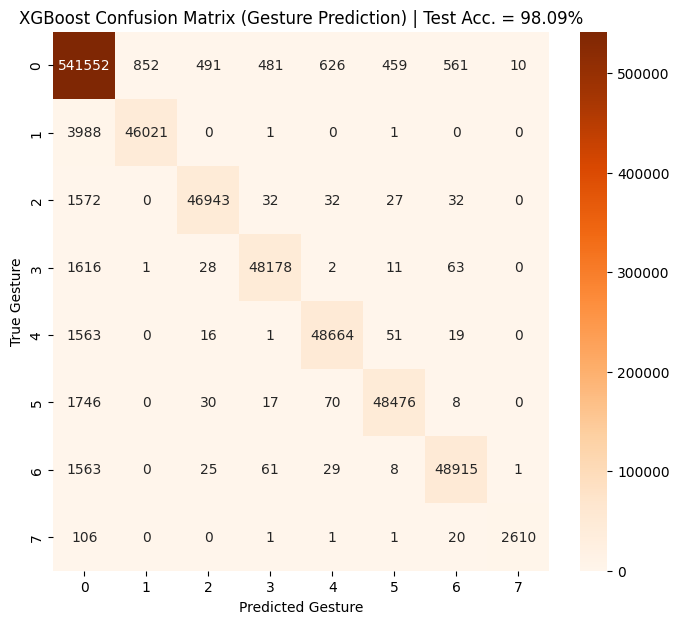

test_accuracy_final: 0.9808596690349725
test_precision_final: 0.9809337676467558
test_recall_final: 0.9808596690349725
test_f1_score_final: 0.9807616091727916
cv_accuracy: 0.9794940013125586
cv_precision: nan
cv_recall: nan
cv_f1_score: nan
Trained XGB Model saved to /content/drive/MyDrive/ML Projects/EMG Gesture Prediction/Results/trained_XGB_classifier.pkl
CPU times: user 3h 6min 50s, sys: 25.4 s, total: 3h 7min 15s
Wall time: 24min 51s


In [90]:
%%time

X_train, X_test, y_train, y_test = train_test_split(features, gesture, test_size=0.2, random_state=1, stratify=gesture)

print(f"train shape: {X_train.shape}")
print(f"test shape: {X_test.shape}")

# Train XGB classifier
model_outputs = fit_XGB_classifier(
    X_train           = X_train,
    X_test            = X_test,
    y_train           = y_train,
    y_test            = y_test,
    num_estimators    = 100,
    max_depth         = 20,
    objective         = 'multi:softmax',
    num_folds         = 5,
    random_state      = 42,
    plot_confusion_TF = True)

for key, value in model_outputs['test_metrics'].items():
    print(f"{key}: {value}")

import os
import pickle
log_dir = '/content/drive/MyDrive/ML Projects/EMG Gesture Prediction/Results'

# Save training history to pickle
filename = 'trained_XGB_classifier.pkl'
model_path = os.path.join(log_dir, filename)

with open(model_path, 'wb') as f:
    pickle.dump(model_outputs['trained_model'], f)
    print(f"Trained XGB Model saved to {model_path}")


## Load Saved XGB Classifier

In [91]:
import os
import pickle
log_dir = '/content/drive/MyDrive/ML Projects/EMG Gesture Prediction/Results'

# Save training history to pickle
filename = 'trained_XGB_classifier.pkl'
model_path = os.path.join(log_dir, filename)

with open(model_path, 'rb') as f:
    xgb_model = pickle.load(f)
print(f"Model loaded from {model_path}")


Model loaded from /content/drive/MyDrive/ML Projects/EMG Gesture Prediction/Results/trained_XGB_classifier.pkl


## Evaluate Loaded XGB Model on Test Data

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Test Accuracy: 99.23%


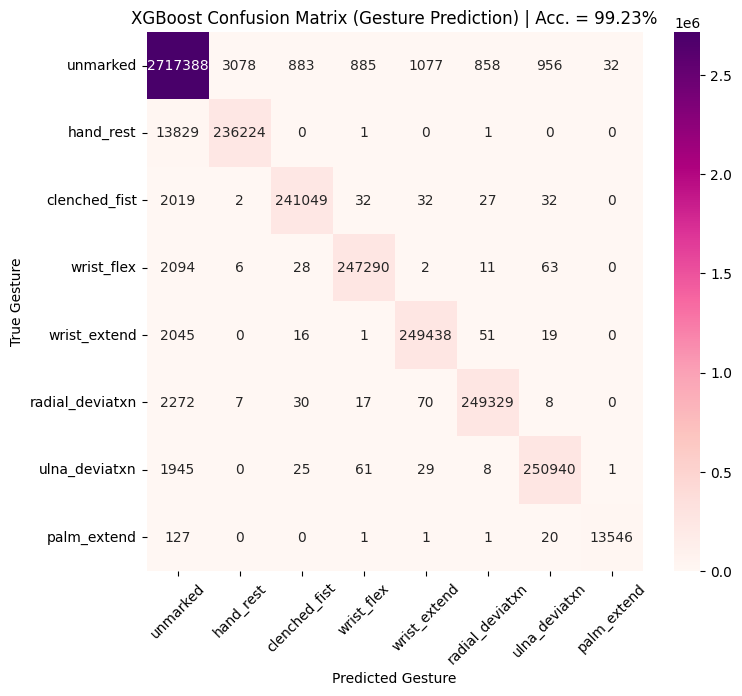

CPU times: user 10min 51s, sys: 475 ms, total: 10min 52s
Wall time: 1min 28s


In [25]:
%%time
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.use('inline')

# supported backend values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template', 'inline']

# X_train, X_test, y_train, y_test = train_test_split(features, gesture, test_size=0.2, random_state=1, stratify=gesture)

# Make predictions on entire dataset
X = features.to_numpy()
y = gesture.to_numpy()

gesture_labels = ["unmarked","hand_rest","clenched_fist","wrist_flex","wrist_extend","radial_deviatxn","ulna_deviatxn","palm_extend"]

# Make predictions
y_pred = xgb_model.predict(X)

conf_matrix = confusion_matrix(y, y_pred)
test_acc = accuracy_score(y, y_pred)
print(f"Test Accuracy: {100*test_acc:.2f}%")

plt.figure(figsize=(8, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdPu', xticklabels=gesture_labels, yticklabels=gesture_labels)
plt.xlabel('Predicted Gesture')
plt.xticks(rotation=45)
plt.ylabel('True Gesture')
plt.title(f'XGBoost Confusion Matrix (Gesture Prediction) | Acc. = {100*test_acc:.2f}%')
plt.show()


# Simulate Realtime Decoding & Save Video

---



In [ ]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend for headless environments
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

win_len = 200
step_size = 50  # 50ms step size

# Load trained XGBoost model
import os
import pickle
log_dir = '/content/drive/MyDrive/ML Projects/EMG Gesture Prediction/Results'

# Save training history to pickle
filename = 'trained_XGB_classifier.pkl'
model_path = os.path.join(log_dir, filename)

with open(model_path, 'rb') as f:
    xgb_model = pickle.load(f)

# Load actual EMG data
X_test = features.to_numpy()[:10000,:]
y_test = gesture.to_numpy()[:10000]

gesture_labels = ["unmarked","hand_rest","clenched_fist","wrist_flex","wrist_extend","radial_deviatxn","ulna_deviatxn","palm_extend"]

# # Make predictions using the trained model
# y_pred = xgb_model.predict(X_test)

# Function for multi-channel EMG plotting
def plot_multichannel_data(ax, emg_window, channel_list, predicted_gesture):
    """
    Plots multi-channel EMG data in a stacked format.

    Parameters:
    - ax: Matplotlib axis to plot on
    - emg_window: EMG signal array for the current window
    - channel_list: List of EMG sensor names
    - predicted_gesture: Gesture label for the current window
    """
    ax.clear()
    c = plt.get_cmap("tab10")  # Colormap
    for idx, chan in enumerate(channel_list):
        ax.plot(np.linspace(0, win_len, len(emg_window)), emg_window[:, idx] + 1*idx, color=c(idx), linewidth=0.5)

    ax.set_xlim(0, win_len)  # Time in ms
    ax.set_yticks(range(len(channel_list)))
    ax.set_yticklabels(channel_list)
    ax.set_xlabel("Time (ms)")
    ax.set_title(f"Predicted Gesture: {predicted_gesture}")

# Initialize figure for animation
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)
channel_list = [f"Sensor_{i+1}" for i in range(X_test.shape[1])]  # Sensor names

# Update function for animation
def update(frame):
    start_idx = frame * step_size
    end_idx = start_idx + win_len
    if end_idx >= len(X_test):
        return

    # Extract EMG window
    emg_window = X_test[start_idx:end_idx, :]

    # Predict gesture using trained model
    predicted_gesture = xgb_model.predict(emg_window.mean(axis=0).reshape(1, -1))[0]

    # Update multi-channel EMG plot
    plot_multichannel_data(ax, emg_window, channel_list, gesture_labels[predicted_gesture])

# Create animation
ani = animation.FuncAnimation(fig, update, frames=range(0, len(X_test)//step_size), interval=step_size, blit=False)

# Save animation as a video file since display is unavailable
output_video_path = "emg_animation.mp4"
ani.save(output_video_path, writer="ffmpeg", fps=20)

# Confirm that the file has been created
output_video_path


# Fit Classifier with 2 Features & Plot Decision Boundary

---



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

cm = plt.cm.plasma # viridis, plasma, cividis
c_map = ListedColormap([cm.colors[0],cm.colors[-1]])
fig,ax = plt.subplots(figsize=(12, 9))

# Initialize XGBoost Classifier with default parameters
xgb_model2 = XGBClassifier(n_estimators=100, max_depth=20,objective='multi:softmax', num_class=len(np.unique(y_test_xgb)), random_state=42)

# Fit the model
X_train_xgb2 = X_train_xgb[:,:2]
xgb_model2.fit(X_train_xgb[:,:2], y_train_xgb)

DecisionBoundaryDisplay.from_estimator(xgb_model2, X_train_xgb2, cmap=c_map, alpha=0.8, ax=ax, eps=0.5)

# Plot the training points
ax.scatter(X_train_xgb2[:, 0], X_train_xgb2[:, 1], c=y_train_xgb, cmap=c_map, edgecolors="k")

# Plot the testing points
ax.scatter(
    x_test_xgb[:, 0],
    x_test_xgb[:, 1],
    c=y_test_xgb,
    cmap=c_map,
    edgecolors="k",
    alpha=0.6,
)

<ipython-input-20-ef8e9aaafcf1>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


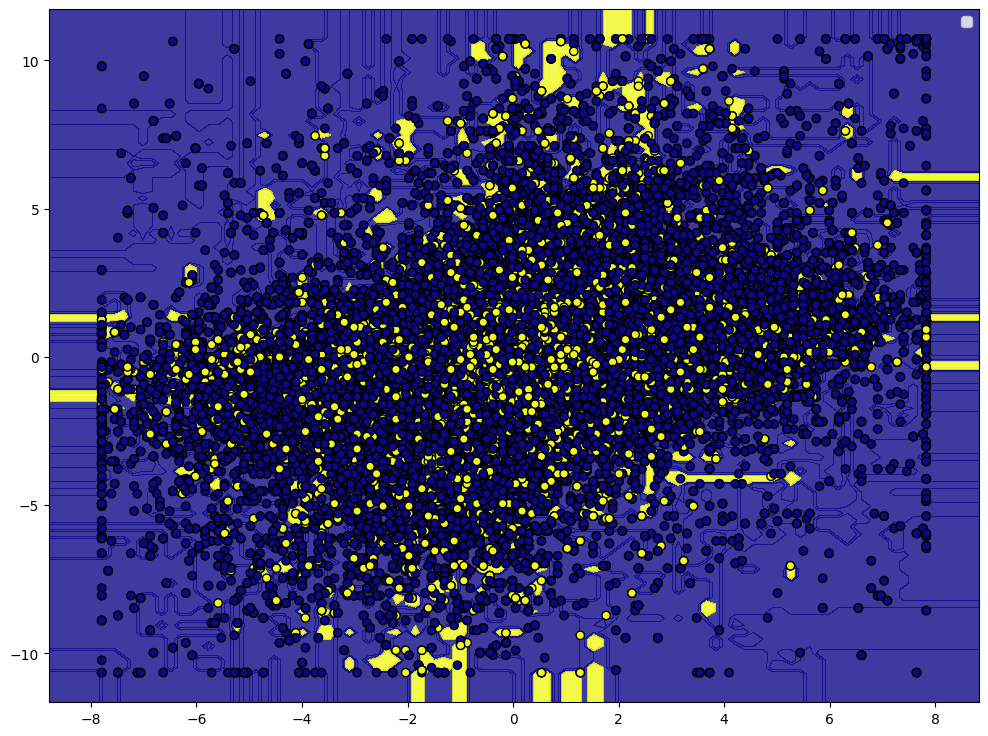

In [20]:
fig,ax=plt.subplots(figsize=(12, 9))
DecisionBoundaryDisplay.from_estimator(xgb_model, X_train_xgb2, cmap=c_map, alpha=0.8, ax=ax)

# Plot the training points
ax.scatter(x_test_xgb[:, 0], x_test_xgb[:, 1], c=y_test_xgb, cmap=c_map, edgecolors="k")
plt.legend()
plt.show()


# Build & Compile EMGNet Model

---



In [41]:
def build_EMGNet(num_electrodes=8, num_gestures=8):
  from tensorflow.keras import layers, Sequential, optimizers, Input, Model

  #----------------- Input Layer -----------------------
  input_tensor = Input(shape=(num_electrodes,))
  # input_tensor = layers.BatchNormalization()(input_tensor)

  #----------------- Hidden Layer 1 -----------------------
  block1 = layers.Dense(1024, activation='relu')(input_tensor)
  # block1 = layers.BatchNormalization()(block1) # always apply batch norm b4 dropout
  # block1 = layers.Dropout(rate=0.25)(block1)

  #----------------- Hidden Layer 2 -----------------------
  block2 = layers.Dense(512, activation='relu')(block1)
  # block2 = layers.BatchNormalization()(block2)
  # block2 = layers.Dropout(rate=0.25)(block2)

  #----------------- Hidden Layer 3 -----------------------
  block3 = layers.Dense(128, activation='relu')(block2)
  # block3 = layers.BatchNormalization()(block3)
  # block3 = layers.Dropout(rate=0.25)(block3)

  #----------------- Hidden Layer 4 -----------------------
  block4 = layers.Dense(64, activation='relu')(block3)
  # block4 = layers.BatchNormalization()(block4)
  # block4 = layers.Dropout(rate=0.25)(block4)

  #----------------- Hidden Layer 5 -----------------------
  block5 = layers.Dense(32, activation='relu')(block4)
  # block5 = layers.BatchNormalization()(block5)
  # block5 = layers.Dropout(rate=0.25)(block5)

  #----------------- Output Layer -----------------------
  output_tensor = layers.Dense(num_gestures, activation='softmax')(block5)

  model = Model(input_tensor, output_tensor)

  #SGD #RMSprop #Adam #Adadelta #Adagrad ##Adamax ###Nadam #Ftrl
  opt = optimizers.Nadam(learning_rate=1e-3)
  model.compile(optimizer = opt,
                loss = "categorical_crossentropy",
                metrics = ["accuracy"])
  return model

model = build_EMGNet()
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1024)                │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 610,280 (2.33 MB)

 Trainable params: 610,280 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # Plot model architecture
# from tensorflow.keras.utils import plot_model

# # Save model diagram as an image
# plot_model(model, to_file="model_architecture.png", show_shapes=True)


# Define Callbacks

---



In [27]:
import tensorflow as tf
import os

def callbacks(log_dir,early_stopping_patience = 2):
    """
    Create TensorBoard logging, early stopping, and model checkpoint callbacks.

    Args:
    log_dir (str): Base directory for logs.
    model_dir (str): Subdirectory where logs and models will be stored.

    Returns:
    list: List of TensorFlow callbacks.
    """
    # Define paths
    model_path = os.path.join(log_dir, "best_model.keras")  # Model file path
    tensorboard_logdir = os.path.join(log_dir, "tensorboard_logs")  # TensorBoard logs

    # Ensure directories exist
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    os.makedirs(tensorboard_logdir, exist_ok=True)

    # Define callbacks
    callbacks_list = [
        tf.keras.callbacks.TensorBoard(
            log_dir=tensorboard_logdir,  # TensorBoard log path
            histogram_freq=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',  # Stop if validation accuracy does not improve
            patience=early_stopping_patience,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=model_path,  # Save model path
            monitor='val_loss',  # Save only the best model
            save_best_only=True
        )]

    return callbacks_list



# Train Model

---



In [42]:
model_num = 2
log_dir = '/content/drive/MyDrive/ML Projects/EMG Gesture Prediction/Results/EMGNet_Callbacks/Model_'+str(model_num)

callback_list = callbacks(log_dir,early_stopping_patience=2)

batch_size = 512
num_epochs = 50

history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs = num_epochs,
                    validation_split = 0.2, callbacks=callback_list)

# Save training history to pickle
history_filename = 'training_history.pkl'
filepath = os.path.join(log_dir, history_filename)
import pickle

with open(filepath, 'wb') as hist_file:
    pickle.dump(history.history, hist_file)



Epoch 1/50
5629/5629 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6434 - loss: 0.9452 - val_accuracy: 0.6466 - val_loss: 0.8877
Epoch 2/50
5629/5629 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6498 - loss: 0.8804 - val_accuracy: 0.6522 - val_loss: 0.8677
Epoch 3/50
5629/5629 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6580 - loss: 0.8543 - val_accuracy: 0.6636 - val_loss: 0.8386
Epoch 4/50
5629/5629 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6703 - loss: 0.8225 - val_accuracy: 0.6753 - val_loss: 0.8100
Epoch 5/50
5629/5629 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6862 - loss: 0.7865 - val_accuracy: 0.6921 - val_loss: 0.7766
Epoch 6/50
5629/5629 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7029 - loss: 0.7513 - val_accuracy: 0.7084 - val_loss: 0.7451
Epoch 7/50
5629/5629 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.7187 - loss: 0.7186 - val_accuracy: 0.7208 - val_loss: 0.7166
Epoch 8/50
5629/5629 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.7325 - loss: 0

KeyboardInterrupt: 

# Load Saved Best Model From Training

---



In [21]:
# loading saved model

from tensorflow.keras.models import load_model

model_num  = 2
EMGNet_model = load_model('/content/drive/MyDrive/ML Projects/EMG Gesture Prediction/Results/EMGNet_Callbacks/Model_'+str(model_num)+'/best_model.keras')
EMGNet_model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1024)                │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,830,843 (6.98 MB)

 Trainable params: 610,280 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,220,563 (4.66 MB)

# Evaluate Model Performance on Test Set

---



In [22]:
# Evaluate the model
_, accuracy_train = EMGNet_model.evaluate(x_train, y_train, verbose=1)
_, accuracy_test  = EMGNet_model.evaluate(x_test, y_test, verbose=1)

print(f"Training accuracy: {accuracy_train * 100:.2f}% | Test accuracy: {accuracy_test * 100:.2f}%")


NameError: name 'x_train' is not defined

# Load & Plot Training Output Metrics

---



<ipython-input-66-635247dade85>:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


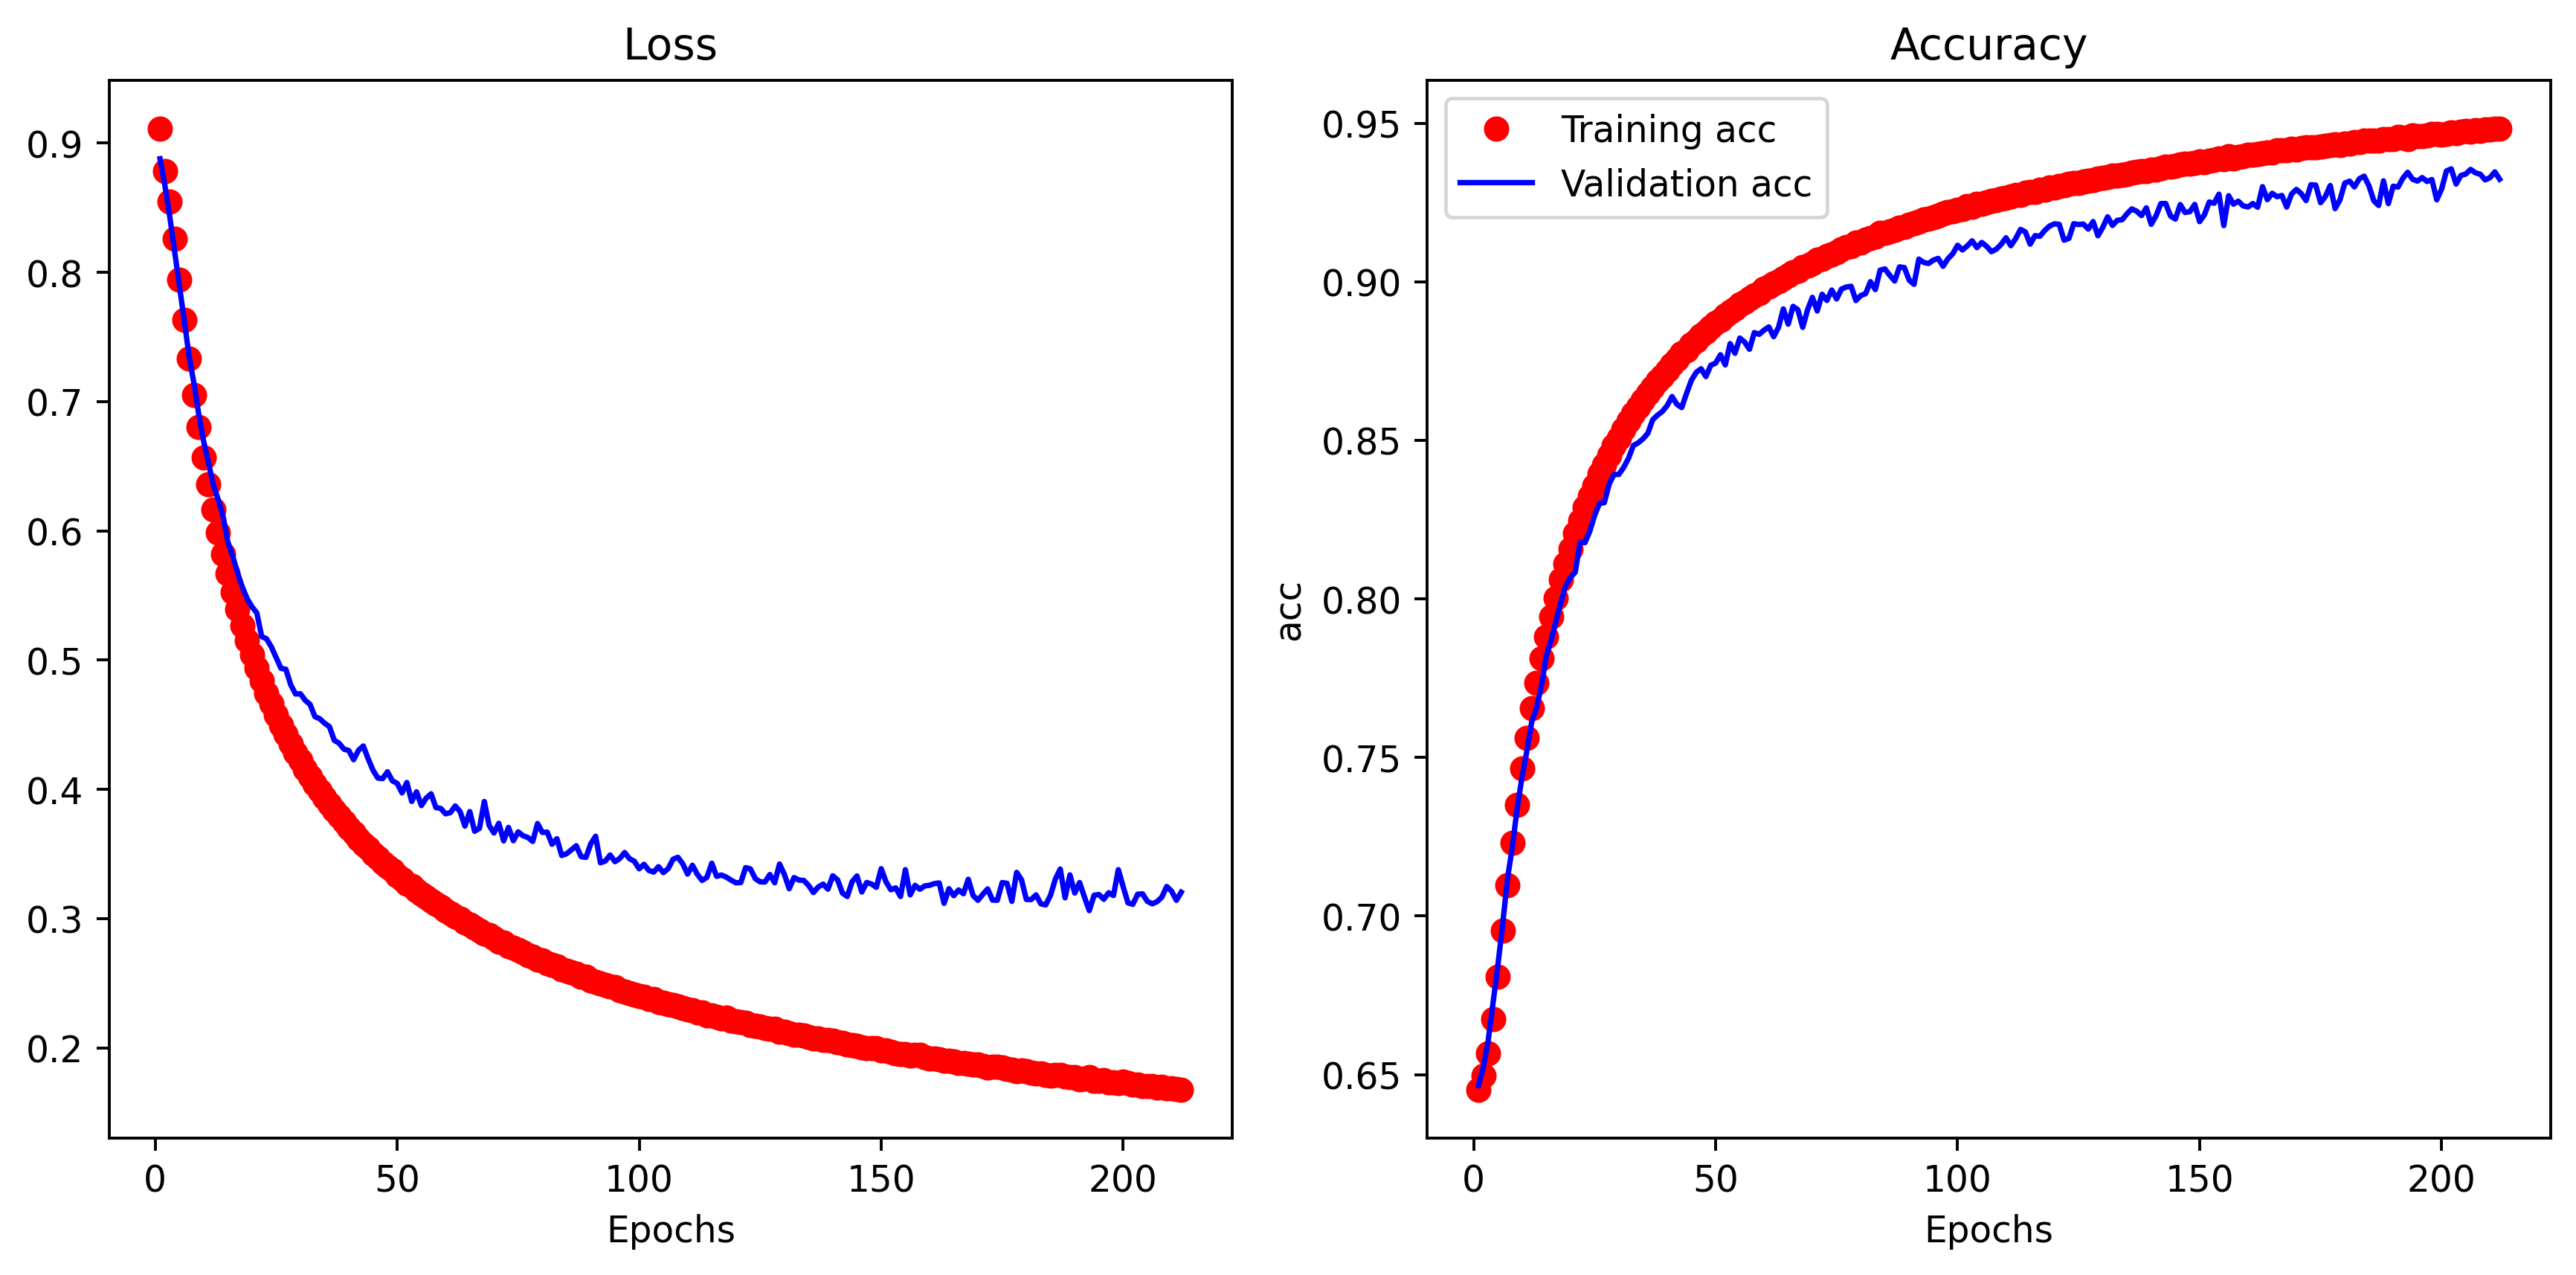

In [ ]:

def plot_output_metrics(history):

    loss = history['loss']
    val_loss = history['val_loss']
    acc = history['accuracy']
    val_acc = history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=350)  # Adjusted for 1 row, 2 columns
    axes = axes.flatten()

    epochs = range(1, len(loss) + 1)

    axes[0].plot(epochs, loss, 'ro', label='Training loss')
    axes[0].plot(epochs, val_loss, 'b', label='Validation loss')
    # plt.title('Training and validation loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    epochs = range(1, len(acc) + 1)

    axes[1].plot(epochs, acc, 'ro', label='Training acc')
    axes[1].plot(epochs, val_acc, 'b', label='Validation acc')
    # plt.title('Training and validation acc')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epochs')
    plt.ylabel('acc')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Load the training history
model_num = 1
log_dir   = '/content/drive/MyDrive/ML Projects/EMG Gesture Prediction/Results/EMGNet_Callbacks/Model_'+str(model_num)
history_filename = 'training_history.pkl'
filepath = os.path.join(log_dir, history_filename)
import pickle

with open(filepath, 'rb') as hist_file:
    history = pickle.load(hist_file)

plot_output_metrics(history)


# Visualize Classification Model Decision Boundaries

---

